In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
customer = pd.read_csv('../../assets/dataset/customer.csv', index_col=None)
event = pd.read_csv('../../assets/dataset/event.csv', index_col=None)

## Derive Labels
* target event: LFE_HOME_PURCHASE
* target event: LFE_RELOCATION

In [3]:
event['EVENT_DATE'] = pd.to_datetime(event['EVENT_DATE'])
event.head()

,CUSTOMER_ID,EVENT_DATE,EVENT_TYPE_ID
0,1103,2013-02-02,INT_OTHER_PHYSICAL
1,1103,2013-02-02,XCT_MORTGAGE_NEW
2,1769,2013-02-03,INT_OTHER_PHYSICAL
3,1769,2013-02-03,XCT_MORTGAGE_NEW
4,1879,2013-02-15,XCT_MORTGAGE_NEW


In [4]:
# peek event data for one customer
event.loc[event['CUSTOMER_ID'] == 1000].head(20)

,CUSTOMER_ID,EVENT_DATE,EVENT_TYPE_ID
999,1000,2014-11-01,INT_OTHER_PHYSICAL
1000,1000,2014-11-01,XCT_MORTGAGE_NEW
1081,1000,2014-11-23,MENTION_LFE_HOME_PURCHASE
1548,1000,2015-03-19,XCT_EQ_SELL
1584,1000,2015-03-26,XFER_FUNDS_OUT_LARGE
1935,1000,2015-06-06,LFE_HOME_PURCHASE
1938,1000,2015-06-06,LFE_RELOCATION
66359,1000,2018-01-02,INT_OTHER_PHYSICAL
66387,1000,2018-01-02,ACNT_SEC_OPEN_*
66393,1000,2018-01-02,ACNT_SEC_OPEN_*


In [23]:
# event distribution
event['EVENT_TYPE_ID'].value_counts().head(20)

XCT_EQ_BUY                   44216
INT_LOGIN_WEB                36578
XCT_EQ_SELL                  11291
XFER_FUNDS_OUT_LARGE          2762
ACNT_SEC_OPEN_*               2614
INT_OTHER_PHYSICAL            1760
XCT_MORTGAGE_NEW               760
LFE_RELOCATION                 717
LFE_HOME_PURCHASE              568
ACNT_SEC_CLOSE_*               436
MENTION_LFE_HOME_PURCHASE      169
BIRTHDAY42                      37
BIRTHDAY69                      37
BIRTHDAY28                      35
BIRTHDAY25                      35
BIRTHDAY27                      34
BIRTHDAY68                      34
BIRTHDAY43                      33
BIRTHDAY29                      33
BIRTHDAY40                      32
Name: EVENT_TYPE_ID, dtype: int64

number of unique customers: 1000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c70447160>]],
      dtype=object)

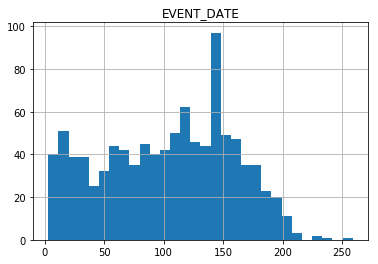

In [6]:
# event distribution per customer
print('number of unique customers:', event['CUSTOMER_ID'].nunique())
event.groupby('CUSTOMER_ID').agg({'EVENT_DATE':'count'}).hist(bins=30)

### Note: 
1. the most common event sequence: login->trade equity
2. per customer, the event sequence is about 100 items
3. the top 3 freq events are: login, buy equity and sale equity
4. XFER_FUNDS_OUT_LARGE is seems to be related to home purchase or relocation event.

### FE Idea
1. Derive label, postive label == target event 
2. count top 11 freq event occurrences before the target event ocurrent date
3. for negative label, count all top 11 event ocurrence

In [7]:
event['home_purchase'] = (event['EVENT_TYPE_ID'] == 'LFE_HOME_PURCHASE').astype(int)
event['life_allocation'] = (event['EVENT_TYPE_ID'] == 'LFE_RELOCATION').astype(int)

In [8]:

data = []
event_list = event['EVENT_TYPE_ID'].value_counts().head(11).index.values
for cid in event['CUSTOMER_ID'].unique():
    
    c = event.loc[event['CUSTOMER_ID'] == cid]
    tmp = c.loc[((c['home_purchase'] ==1) | (c['life_allocation'] ==1)), 'EVENT_DATE']
    
    # get event sequence for input customer id
    if len(tmp) > 0:
        end_date = tmp.max()
    else:
        end_date = c['EVENT_DATE'].max()
    
    # get valid events
    c = c.loc[c['EVENT_DATE'] <= end_date]

    # count event
    event_df = c.groupby(['EVENT_TYPE_ID']).agg({'EVENT_DATE':'count'})

    # build data row
    row = []
    for e in event_list:
        if e in event_df.index:
            row.append(event_df.loc[e,'EVENT_DATE']) # the count of occurrence
        else:
            row.append(0)
            
    # add labels
    row.append(c['home_purchase'].max())
    row.append(c['life_allocation'].max())
    row.append(end_date)
    row.append(cid)
    data.append(row)

In [9]:
# build dataframe
columns = list(event_list)
columns.extend(['home_purchase','life_allocation','event_date','customer_id'])
df1 = pd.DataFrame(data, columns=columns).drop(['LFE_RELOCATION','LFE_HOME_PURCHASE'], axis=1)
print(df1.shape)
df1.head()

(1000, 13)


,XCT_EQ_BUY,INT_LOGIN_WEB,XCT_EQ_SELL,XFER_FUNDS_OUT_LARGE,ACNT_SEC_OPEN_*,INT_OTHER_PHYSICAL,XCT_MORTGAGE_NEW,ACNT_SEC_CLOSE_*,MENTION_LFE_HOME_PURCHASE,home_purchase,life_allocation,event_date,customer_id
0,0,0,0,1,0,1,1,0,0,1,1,2014-01-21,1103
1,0,0,0,0,0,1,1,0,0,1,1,2014-01-19,1769
2,0,0,0,0,0,1,1,0,0,1,1,2014-01-05,1879
3,75,54,20,1,3,2,1,0,0,0,0,2018-09-30,1461
4,57,42,13,11,3,2,1,0,0,0,0,2018-09-30,1656


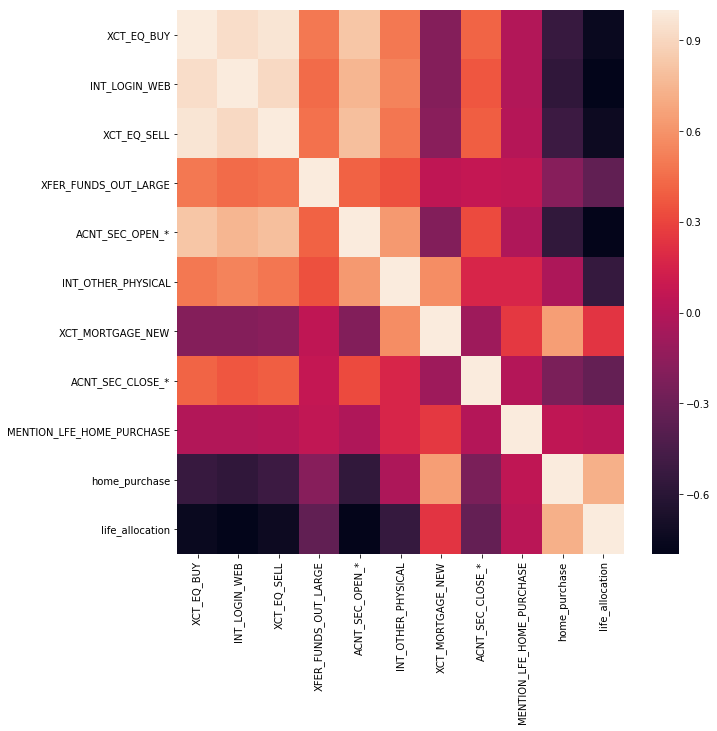

In [10]:
# check corr
import seaborn as sns
plt.figure(figsize = (10,10))
sns.heatmap(df1.loc[:, :'event_date'].corr())

,XCT_EQ_BUY,INT_LOGIN_WEB,XCT_EQ_SELL,XFER_FUNDS_OUT_LARGE,ACNT_SEC_OPEN_*,INT_OTHER_PHYSICAL,XCT_MORTGAGE_NEW,ACNT_SEC_CLOSE_*,MENTION_LFE_HOME_PURCHASE,home_purchase,life_allocation
home_purchase,-0.533919,-0.571698,-0.512270,-0.182883,-0.559483,-0.031553,0.644364,-0.238125,0.048525,1.000000,0.720387
life_allocation,-0.749611,-0.796834,-0.734708,-0.342781,-0.788577,-0.537881,0.239523,-0.330552,0.028594,0.720387,1.000000


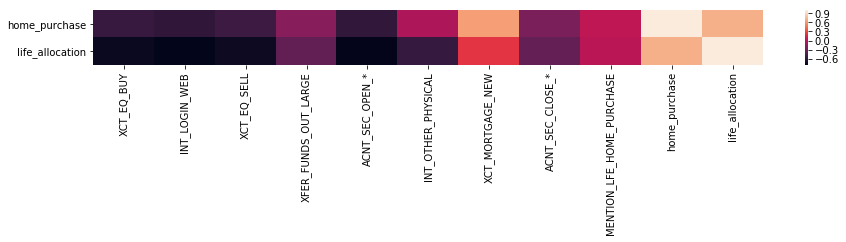

In [11]:
plt.figure(figsize = (15,1))
sns.heatmap(df1.loc[:, :'event_date'].corr()['home_purchase':])
df1.loc[:, :'event_date'].corr()['home_purchase':]

In [12]:
# check the postive rate of label
print(df1['home_purchase'].sum()/df1.shape[0])
print(df1['life_allocation'].sum()/df1.shape[0])

0.568
0.717


# FE customer data

In [13]:
# null rate
foo = customer.isna().sum()/customer.shape[0]
foo = foo.loc[foo < .3]
df2=customer.loc[:, foo.index]
df2['EFFECTIVE_DATE'] = pd.to_datetime(df2['EFFECTIVE_DATE'])
df2.head()

,ACQUISITION_COST,ADDRESS_HOME_CITY,ADDRESS_HOME_COUNTRY,ADDRESS_HOME_POSTAL_CODE,ADDRESS_HOME_STATE,ADDRESS_LAST_CHANGED_DATE,ADDRESS_MAILING_CITY,ADDRESS_MAILING_COUNTRY,ADDRESS_MAILING_POSTAL_CODE,ADDRESS_MAILING_STATE,...,RELATIONSHIP_START_DATE,RETIREMENT_AGE,SATISFACTION_RATING_FROM_SURVEY,SECONDARY_ADVISOR_ID,SECONDARY_ADVISOR_ORGANIZATION_ID,SPECIAL_TERMS_INDICATOR,STATUS,STATUS_DATE,URBAN_CODE,WALLET_SHARE_PERCENTAGE
0,55.026993,Emerald City,USA,B1Z,Indiana,2015-06-06,Emerald City,USA,B1Z,Indiana,...,2018-01-02,67,satisfied,84892,119167,True,Active,2018-01-02,City,21
1,55.026993,Emerald City,USA,B1Z,Indiana,2015-06-06,Emerald City,USA,B1Z,Indiana,...,2018-01-02,67,satisfied,84892,119167,True,Active,2018-01-02,City,21
2,19.712715,Coruscant,USA,K0K,New,2015-03-27,Coruscant,USA,K0K,New,...,2017-11-29,67,very dissatisfied,139890,76403,True,Active,2017-11-29,Urban,18
3,19.712715,Coruscant,USA,K0K,New,2015-03-27,Coruscant,USA,K0K,New,...,2017-11-29,67,very dissatisfied,139890,76403,True,Active,2017-11-29,Urban,18
4,81.473346,Metropolis,Canada,G1K,QC,2015-01-31,Metropolis,Canada,G1K,QC,...,2017-08-28,67,very satisfied,74116,82349,True,Active,2017-08-28,Urban,45


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c7333ac18>]],
      dtype=object)

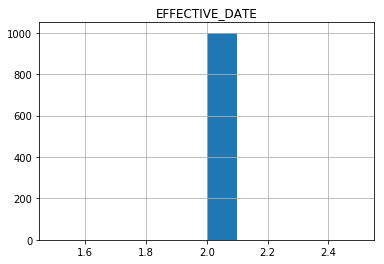

In [14]:
df2.groupby('CUSTOMER_ID').agg({'EFFECTIVE_DATE':'count'}).hist()

In [15]:
## fillna by zero
df2 = df2.fillna(0)

In [27]:
##
# keep numeric value only
keeps = []
dtypes = df2.dtypes
for i,t in enumerate(dtypes):
    if str(t) == "object" or str(t) == "bool":
        continue
    else:
        keeps.append(dtypes.index[i])
df3 = df2.loc[:, keeps]
df3['EFFECTIVE_DATE'] = df2['EFFECTIVE_DATE']
df3['GENDER'] = (df2['GENDER']=='Male').values.astype(int)
df3.head()

,ACQUISITION_COST,ANNUAL_INCOME,BIRTH_YEAR,CREDIT_SCORE,CREDIT_UTILIZATION,CUSTOMER_ID,DEBT_SERVICE_COVERAGE_RATIO,EFFECTIVE_DATE,FAMILY_SIZE,HOUSEHOLD_ID,...,NUMBER_OF_DEPENDENT_ADULTS,NUMBER_OF_DEPENDENT_CHILDREN,PRIMARY_ADVISOR_ID,PRIMARY_BRANCH_PROXIMITY,RECORDED_VOICE_SAMPLE_ID,RETIREMENT_AGE,SECONDARY_ADVISOR_ID,SECONDARY_ADVISOR_ORGANIZATION_ID,WALLET_SHARE_PERCENTAGE,GENDER
0,55.026993,325000.0,1981,676.994819,0.193144,1000,1.0,2018-01-02,3,1000,...,0,1,1015.0,501.569161,138826,67,84892,119167,21,1
1,55.026993,325000.0,1981,676.994819,0.193144,1000,1.0,2000-01-01,3,1000,...,0,1,1015.0,501.569161,138826,67,84892,119167,21,1
2,19.712715,280000.0,1934,682.276018,0.485421,1001,1.0,2017-11-29,1,1001,...,0,0,1003.0,426.054614,90900,67,139890,76403,18,0
3,19.712715,280000.0,1934,682.276018,0.485421,1001,1.0,2000-01-01,1,1001,...,0,0,1003.0,426.054614,90900,67,139890,76403,18,0
4,81.473346,130000.0,1954,799.567100,0.003393,1002,1.0,2017-08-28,2,1002,...,0,0,1005.0,201.504638,59984,67,74116,82349,45,0


## Merge Dataset

In [28]:
df = pd.merge(df3, df1, how='right',
                 left_on=["CUSTOMER_ID"], 
                 right_on=["customer_id"])

df = df.loc[df['event_date']-df['EFFECTIVE_DATE'] < np.timedelta64(1500, 'D'), :] # within five years roughly
df = df.drop(['CUSTOMER_ID','EFFECTIVE_DATE'], axis=1)
print(df.shape)
df.head()

(1000, 35)


,ACQUISITION_COST,ANNUAL_INCOME,BIRTH_YEAR,CREDIT_SCORE,CREDIT_UTILIZATION,DEBT_SERVICE_COVERAGE_RATIO,FAMILY_SIZE,HOUSEHOLD_ID,INFLUENCE_SCORE,LOYALTY_RATING_CODE,...,XFER_FUNDS_OUT_LARGE,ACNT_SEC_OPEN_*,INT_OTHER_PHYSICAL,XCT_MORTGAGE_NEW,ACNT_SEC_CLOSE_*,MENTION_LFE_HOME_PURCHASE,home_purchase,life_allocation,event_date,customer_id
0,55.026993,325000.0,1981,676.994819,0.193144,1.0,3,1000,68387,83197,...,1,0,1,1,0,1,1,1,2015-06-06,1000
2,19.712715,280000.0,1934,682.276018,0.485421,1.0,1,1001,131758,80883,...,0,0,0,0,0,0,0,1,2015-03-27,1001
4,81.473346,130000.0,1954,799.567100,0.003393,1.0,2,1002,72552,54611,...,0,2,1,0,0,0,0,0,2018-09-30,1002
6,58.943523,120000.0,1950,733.356329,0.710169,1.0,2,1003,49482,107792,...,0,0,0,0,0,0,0,1,2017-10-08,1003
8,74.091664,350000.0,1975,676.398420,0.698750,1.0,4,1004,144341,64163,...,1,0,1,1,0,0,1,1,2016-10-26,1004


,ACQUISITION_COST,ANNUAL_INCOME,BIRTH_YEAR,CREDIT_SCORE,CREDIT_UTILIZATION,DEBT_SERVICE_COVERAGE_RATIO,FAMILY_SIZE,HOUSEHOLD_ID,INFLUENCE_SCORE,LOYALTY_RATING_CODE,...,INT_LOGIN_WEB,XCT_EQ_SELL,XFER_FUNDS_OUT_LARGE,ACNT_SEC_OPEN_*,INT_OTHER_PHYSICAL,XCT_MORTGAGE_NEW,ACNT_SEC_CLOSE_*,MENTION_LFE_HOME_PURCHASE,home_purchase,life_allocation
home_purchase,-0.020731,-0.024920,0.498046,-0.015945,-0.001783,NaN,0.408714,0.037288,-0.022731,0.006018,...,-0.571698,-0.512270,-0.182883,-0.559483,-0.031553,0.644364,-0.238125,0.048525,1.000000,0.720387
life_allocation,-0.012189,-0.037196,0.201858,-0.040117,0.022828,NaN,0.149421,0.063540,-0.004325,-0.002666,...,-0.796834,-0.734708,-0.342781,-0.788577,-0.537881,0.239523,-0.330552,0.028594,0.720387,1.000000


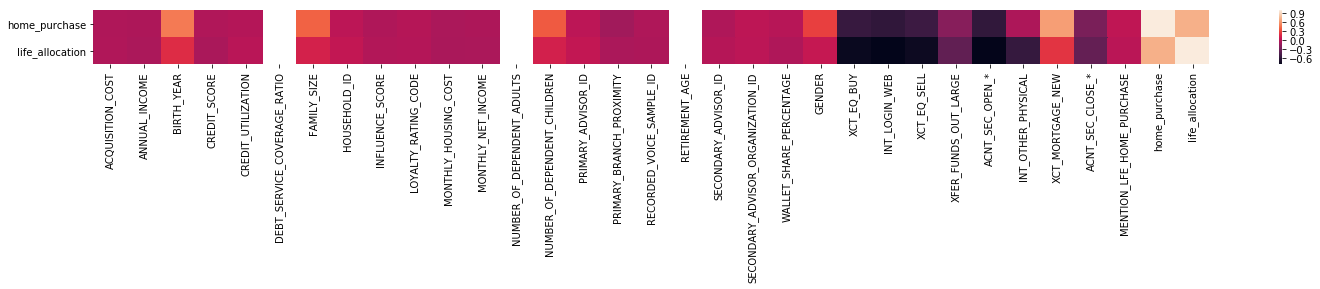

In [29]:
# check corr
plt.figure(figsize = (25,1))
sns.heatmap(df.loc[:, :'life_allocation'].corr()['home_purchase':])
df.loc[:, :'life_allocation'].corr()['home_purchase':]

### Build Training Dataset
1. for baseline model, only pick the feature which has > .1 corr efficient

In [34]:
# save dataset for life_allocation classification
keeps = np.abs(df.loc[:, :'life_allocation'].corr()['life_allocation']) > 0.1
df_lfe = df.loc[:, keeps.values].drop('home_purchase',axis=1)
df_lfe['GENDER'] = df['GENDER']
print(df_lfe['life_allocation'].value_counts())
df_lfe.head()

1    717
0    283
Name: life_allocation, dtype: int64


,BIRTH_YEAR,FAMILY_SIZE,NUMBER_OF_DEPENDENT_CHILDREN,XCT_EQ_BUY,INT_LOGIN_WEB,XCT_EQ_SELL,XFER_FUNDS_OUT_LARGE,ACNT_SEC_OPEN_*,INT_OTHER_PHYSICAL,XCT_MORTGAGE_NEW,ACNT_SEC_CLOSE_*,life_allocation,GENDER
0,1981,3,1,0,0,1,1,0,1,1,0,1,1
2,1934,1,0,0,0,0,0,0,0,0,0,1,0
4,1954,2,0,24,26,6,0,2,1,0,0,0,0
6,1950,2,0,0,0,0,0,0,0,0,0,1,0
8,1975,4,2,0,0,1,1,0,1,1,0,1,1


In [35]:
df_lfe.to_csv('../../assets/dataset/relocation_db_with_gender.csv', index=None)

In [21]:
# save dataset for house_purchase event
keeps = np.abs(df.loc[:, :'life_allocation'].corr()['home_purchase']) > 0.1
df_home = df.loc[:, keeps.values].drop('life_allocation',axis=1)
print(df_home['home_purchase'].value_counts())
df_home.head()

1    568
0    432
Name: home_purchase, dtype: int64


,BIRTH_YEAR,FAMILY_SIZE,NUMBER_OF_DEPENDENT_CHILDREN,XCT_EQ_BUY,INT_LOGIN_WEB,XCT_EQ_SELL,XFER_FUNDS_OUT_LARGE,ACNT_SEC_OPEN_*,XCT_MORTGAGE_NEW,ACNT_SEC_CLOSE_*,home_purchase
0,1981,3,1,0,0,1,1,0,1,0,1
2,1934,1,0,0,0,0,0,0,0,0,0
4,1954,2,0,24,26,6,0,2,0,0,0
6,1950,2,0,0,0,0,0,0,0,0,0
8,1975,4,2,0,0,1,1,0,1,0,1


In [22]:
df_home.to_csv('../../assets/dataset/home_db.csv', index=None)